<h1>Содержание<span class="tocSkip"></span></h1>

<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с AutoModelForSequenceClassification

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [10]:
!pip install --upgrade scikit-learn -q
!pip install torch -q
!pip install --upgrade transformers -q

In [11]:
# импортируем библиотеки
import pandas as pd 
import os
import re
import numpy as np
import matplotlib.pyplot as plt 
import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

import seaborn as sns 
sns.set(style="whitegrid")

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline 

from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import f1_score

import warnings 
warnings.filterwarnings("ignore") 

## Подготовка

In [12]:
# варианты путей
possible_paths = [
    '/Users/masha/Downloads/toxic_comments.csv',  
    '/home/jupyter/toxic_comments.csv',
    '/datasets/toxic_comments.csv'
]

for path in possible_paths:
    if os.path.exists(path):
        try:
            data = pd.read_csv(path)
            print(f"Файл успешно загружен из: {path}")
            break
        except Exception as e:
            print(f"Ошибка при чтении файла: {e}")
else:
    print("Файл не найден ни по одному из указанных путей.")

data.head()

Файл успешно загружен из: /datasets/toxic_comments.csv


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [13]:
# удаляем ненужный столбец
data = data.drop('Unnamed: 0', axis = 1)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [15]:
# проверим пропуский в данных и явные дубликаты
def check_missing_and_duplicates (data):
    print('Пропуски в таблице:')
    print(data.isna().sum())
    duplicates = data.duplicated().sum()
    print()
    if duplicates>0:
        data.drop_duplicates(inplace=True)
        print(f'Явные дубликаты удалены! Их было {duplicates}.')
    else:
        print('Нет явных дубликатов! \n')
        
check_missing_and_duplicates(data)

Пропуски в таблице:
text     0
toxic    0
dtype: int64

Нет явных дубликатов! 



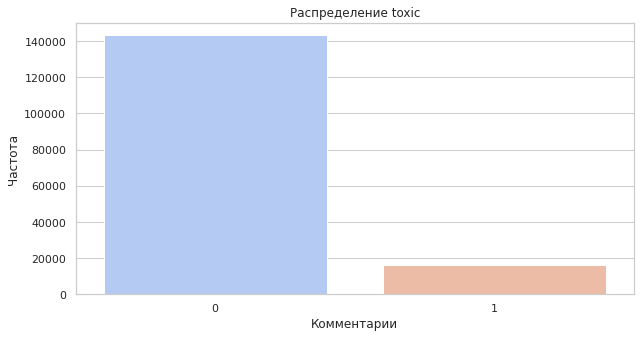

In [16]:
# визуализируем распределение целевого признака
plt.figure(figsize=(10, 5))
sns.countplot(x=data['toxic'], palette="coolwarm")
plt.title(f'Распределение toxic')
plt.xlabel('Комментарии')
plt.ylabel('Частота')
plt.show()

Токсичных комментариев гораздо меньше, поэтому нужна будет либо балансировка классов, либо стратификация.

In [17]:
# очищаем комментарии от "мусора"
def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)                      
    text = re.sub(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', ' ', text) 
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)     
    text = re.sub(r'\S+@\S+', ' ', text)                     
    text = re.sub(r'[^A-Za-z0-9\s.,!?]', ' ', text)          
    text = re.sub(r'\s+', ' ', text).strip()                 
    return text

# применяем к тексту перед токенизацией
data['text'] = data['text'].apply(clean_text)
data.head()

,text,toxic
0,Explanation Why the edits made under my userna...,0
1,D aww! He matches this background colour I m s...,0
2,"Hey man, I m really not trying to edit war. It...",0
3,More I can t make any real suggestions on impr...,0
4,"You, sir, are my hero. Any chance you remember...",0


In [18]:
# беру случаную выборку, так как всю не тянет комп, либо очень долго
sampled_data = data.sample(n=10000, random_state=42) 

In [19]:
# загружаем токенизатор и модель, дообученную на токсичных данных
model_name = "unitary/toxic-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [20]:
# применяем к очищенному тексту
encoded = tokenizer(
    list(sampled_data['text']),
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors='pt'
)

dataset = TensorDataset(encoded['input_ids'], encoded['attention_mask'])
loader = DataLoader(dataset, batch_size=32)

In [21]:
logit_features = []

for batch in tqdm(loader, desc="Toxic-BERT batches"):
    input_ids, attention_mask = [x.to(device) for x in batch]

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # форма: [batch_size, 6]

    logit_features.append(logits.cpu().numpy())

# объединяем все батчи в один массив
features = np.concatenate(logit_features)  # shape: (num_samples, 6)


Toxic-BERT batches: 100%|██████████| 313/313 [1:35:38<00:00, 18.33s/it]


*В данном разделе была произведена очистка текста от "мусора", токенизация, а так же получены логиты токсичности (признаки).*

## Обучение

In [22]:
# обучаем и тестируем модели, сначала создаем выборки 
X = features
y = sampled_data['toxic']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [23]:
# логистическая регрессия
lr_pipe = Pipeline([
    ('model', LogisticRegression(random_state=42))
])

lr_params = {
    'model__C': [0.1, 1, 10], 
    'model__solver': ['lbfgs', 'liblinear']
}

lr_grid = RandomizedSearchCV(
    lr_pipe, 
    lr_params, 
    scoring='f1',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
lr_grid.fit(X_train, y_train)

# градиентный бустинг
gb_pipe = Pipeline([
    ('model', GradientBoostingClassifier(random_state=42))
])

gb_params = {
    'model__n_estimators': [50, 100],
    'model__learning_rate': [0.01, 0.1, 0.5],
    'model__max_depth': [3, 5]
}

gb_grid = RandomizedSearchCV(
    gb_pipe, 
    gb_params, 
    scoring='f1',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

gb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=   0.4s
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=   0.4s
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=   0.4s
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=   0.4s
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=   0.5s
[CV] END ..............model__C=0.1, model__solver=liblinear; total time=   0.1s
[CV] END ..............model__C=0.1, model__solver=liblinear; total time=   0.0s
[CV] END ..............model__C=0.1, model__solver=liblinear; total time=   0.0s
[CV] END ..............model__C=0.1, model__solver=liblinear; total time=   0.0s
[CV] END ..............model__C=0.1, model__solver=liblinear; total time=   0.0s
[CV] END ....................model__C=1, model__solver=lbfgs; total time=   0.3s
[CV] END ....................model__C=1, model__s

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('model',
                                              GradientBoostingClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'model__learning_rate': [0.01, 0.1,
                                                                 0.5],
                                        'model__max_depth': [3, 5],
                                        'model__n_estimators': [50, 100]},
                   random_state=42, scoring='f1', verbose=2)

In [24]:
# сравнение моделей на кросс-валидации
print("Лучшая F1 логистической регрессии:", lr_grid.best_score_)
print("Лучшие параметры логистической регрессии:", lr_grid.best_params_)
print()

print("Лучшая F1 градиентного бустинга:", gb_grid.best_score_)
print("Лучшие параметры градиентного бустинга:", gb_grid.best_params_)
print()

# выбираем лучшую модель
best_model = max(
    [(lr_grid, 'Logistic Regression'), (gb_grid, 'Gradient Boosting')],
    key=lambda x: x[0].best_score_
)[0]

print(f"Лучшая модель: {best_model.best_estimator_}")

# оценка на тестовой выборке
y_pred = best_model.predict(X_test)
test_f1 = f1_score(y_test, y_pred)
print(f"F1 на тестовой выборке: {test_f1:.4f}")

Лучшая F1 логистической регрессии: 0.9390162460682726
Лучшие параметры логистической регрессии: {'model__solver': 'liblinear', 'model__C': 10}

Лучшая F1 градиентного бустинга: 0.9334691798267958
Лучшие параметры градиентного бустинга: {'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.1}

Лучшая модель: Pipeline(steps=[('model',
                 LogisticRegression(C=10, random_state=42,
                                    solver='liblinear'))])
F1 на тестовой выборке: 0.9259


<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>образец комментария студента</b></font>
    
   Исправила на модель, дообученную на токсичность (unitary/toxic-bert).
</div>

**В итоге:**

Лучшая модель: Pipeline(steps=[('model',
                 LogisticRegression(C=10, random_state=42, solver='liblinear'))])
                 
**F1 на тестовой выборке: 0.9259** Трансформерная структура показывает отличные результаты.

## Выводы

В данном проекте были выполнены следующие задачи:
- загружены и подготовлены данные
- обучена модель логистической регрессии и градиентного бустинга
- лучшая модель это LogisticRegression(C=1, random_state=42, solver='liblinear')
- метрика F1 на тестовой выборке: 0.9259